# Chapter 4 Training Models

So far we have treated Machine Learning models and their training algorithms mostly like black boxes.If you went through some of the exercises in the previous chapters,you may have been surprised by how much you can get done without knowing anything about what's under the hood:you optimised a regression system,you improved a digit image classifer,and you even built a sapm classifer from scratch,all this without knowing how they actually work.Indeed, in many situations you do not really know the implementation details.

However,having a good understanding of how things work can help you quickly home in on the appropriate model,the right training algorithm to use,and a good set of hyperparameters for your task.Undersatanding what is under the hood will also help you debug issues and perform error analysis more efficiently.Lastly,most of the topics discussed in this chapter will be essential i understanding,building,and training neural networks(discussed in Part 2 of this book).

In this chapter we will start by looking at the Linear Regression model,one of the simplest models there is .We will discuss two very different ways to train it:

* Using a direct "closed-form" equation that directly computes the model parameters that best fit the model to the training set(i.e.,  the model parameters that minimize the cost function over the training set)

* Using an iterative optimization approach called Gradient(CD) that gradually tweaks the model parameters to minimize the cost function over the training set,eventually converging to the same set of paramaters as the first method.We will look at a few variants of Gradient Descent that we will use again and again when we study neural networks in PARAT 2.

Next we will look at Polynomial Regression,a more complex model that can fit non-linear datasets. Since this model has more parameters than Linear Regression,it is more prone to overfitting the training data,so we will look at how to detect whether or not this is the case using learning curves, and then we will look at several regularization techniques that can reduce the risk of overfitting the training set.

Finally,we will look at two more models that are commonly used for classification tasks: Logistic Regression and Softmax Regression.

There will be quite a few math equations in this chapter,using basic notions of linear algebra and calclus. To understand these equations,you will need to know what vectors and matrices are;how to transpose them ,multiply them,and inverse them;and what partial derivatives are.If you are unfamiliar with these concepts,please go through the linear algebra and calculus introductory tutorials available as Jupyter notebooks in the online supplemental material.For those who are truly allergic to mathematics, you should still go through this chapter and simply skip the equations;hopefully, the text will be sufficient to help you understand most of the concepts.

# Linear regression
More generally, a linear model makes a prediction by simply computing a weighted sum of the input features,plus a constant called the bias term(also called the intercept term),as shown in Equation 4-1.

Equation4-1 Linear Regression model prediction

# The Normal Equatin

Let us generate some linear-looking data to test this equation

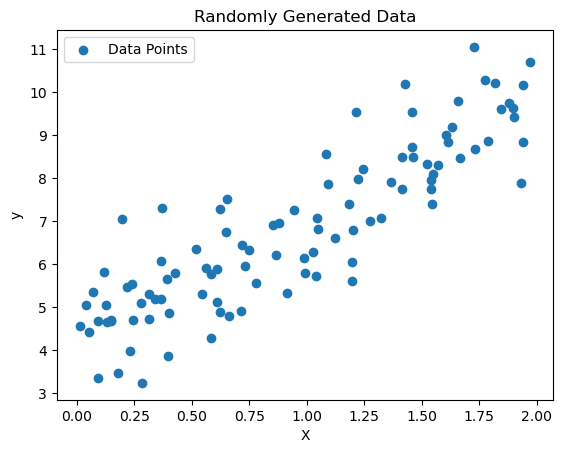

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Generate random data
np.random.seed(42)
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

# Plot the generated data
plt.scatter(X, y, label='Data Points')
plt.title('Randomly Generated Data')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()



In [3]:
X_b = np.c_[np.ones((100, 1)), X] # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)


The functionthat we used to generate the data is  y = 4 + 3x1 + Gaussian noise.Let us see what the equation found

In [4]:
theta_best

array([[4.21509616],
       [2.77011339]])

Close enough,but the noise made it impossible to recover the exact parameters of the original function.Now we can make predictions using 

In [9]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new] # add x0 = 1 to each instance
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.21509616],
       [9.75532293]])

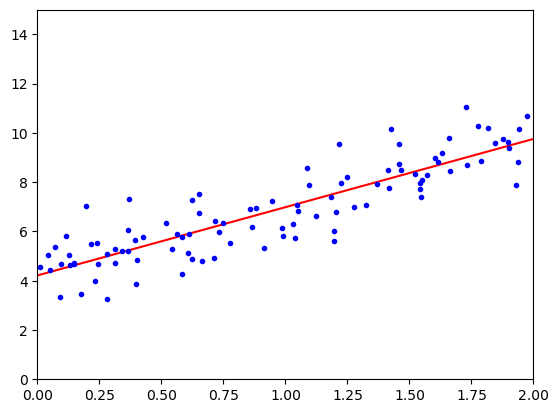

In [12]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

figure 4-2 Linear regression model predictions
Performing Linear Regression using Scikit-leaen is simple:

In [13]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_


(array([4.21509616]), array([[2.77011339]]))

The LinearRegression class is based on the scipy.linalg.lstsq() function(the name stands for "least squares"),which you could call directly:

In [14]:
>>> theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
>>> theta_best_svd

array([[4.21509616],
       [2.77011339]])

1.Normal Equation('theta_best')
2.Scikit-Learn's 'LinearRegssion'
3.Pseudoinverse with SVD('theta_best_svd'):

Three approaches aim to find the optimal parameters for a linear regression model.
The Normal Equation and the pseudoinverse methds are closely related,but the pseudinverse is more numerically stable.
Scikit-Learn's LinearRegression provides a convenient and efficient way to perform linear regression without explicitly dealing with matrix inversions or pseudoinverses.

# 4.1.2 Computational Complexity
The Normal Equation computes the inverse of XtX,which is an  (n+1)X(n+1) matrix(where n is the number of features). The computational complexity of inverting such a matrix is typically about ,depending on the implementation.

Now we will look at a very different way to train a Linear Regression model,which is better suited fro cases for cases where there are a large number of features or too many training instances to fit in memory.

# 4.2 Gradient Descent
Gradient Descent is a generic optimization algorithm capable of finding optimal solutions  to a wide range of problems.The genreal idea of gradient Descent is to tweak parameters iteratively in order to minimize a cost function.

Concretely,you start by filling @ with random values (this is called random initialization).Then you improve it gradually,taking one babby step at a time,each step attempting to decrease the cost function(e.g.,the MSE),until the algorithm converges to a minimum.

In this depiction of Gradient Descent, the model parameters are intialized randomly and get tweaked repeatedly to minimize the cost function;the learning step size is proportional to the slope of the cost fucnction ,so the steps gradually get smaller as the parameters approach the minimum.

An important parameter in Gradient Dwscent is the size of the steps,determined by the learning rate hyperparameter.If the learning rate is too small,then the algorithm will have to go through many iterations to converge,which will take a long time.

When using Gradient Descent,you should ensure that all features have a similar scale (e.g.,using Scikit-Learn's StandardScaler class), or else it will take much longer to converge.

Fortunately,since the cost function is convex in the case of Linear Regression,the needle is simply at the bottom of the bowl.

# 4.2.1 Batch gradient Descent
Equation  Partial derivatives of the cost function
Gradient vector of the cost function

